# Artificial Intelligence and Modern Physics: a Two Way Connection

The following is part of the hands-on sessions of the [AIPhy](https://aiphy.fisica.unimib.it/) school.
The notebook aims at giving an **introduction to machine learning** methods in Python.
Tutorials deal with different **unsupervised and supervised algorithms**.
Students will learn how to build these algorithms from scratch using basic Python classes.
They will then apply different techniques to test and evaluate them on toy and real world datasets.

## Preliminary Actions

I recommend you use a Python **virtual environment** to setup your work area:

```bash
python -m venv venv
```

At the time of writing the Python version is `3.10.12`: you can change this either with your distribution package manager, or by installing a **Conda** environment (e.g. `conda create -y -n aiphy python"==3.10.12" && conda activate aiphy`).

You can then activate it with:

```bash
source venv/bin/activate
```

Before we begin, remember to install the requirements:

```bash
pip install -r requirements.txt
```

We shall use mainly the `numpy` library for the algorithms, and the `matplotlib` library for plots.

## Principal Components Analysis

**Principal Components Analysis** (PCA) is a technique introduced by Karl Pearson in [1901](https://doi.org/10.1080/14786440109462720).
The basic idea of the technique is to find the main directions of variation in a dataset.
This can be achieved by fitting an ellipsoid to the data which is then projected on these directions.

### PCA Through Singular Value Decomposition

PCA acts as a (pseudo-)rotation on the a data matrix $X = \left( x_{(i)}^T \right)_{i = 1, \dots, n}$, where $x_{(i)} \in \mathbb{R}^p$ are column vectors:

$$
X^{\prime} = X W.
$$

The matrix $W$ is a $p \times p$ matrix of _loadings_ whose columns are eigenvectors of the covariance matrix $C = (n - 1)^{-1} X^T X$, which automatically ensures that:

$$
\forall k = 1, 2, \dots, p,
\quad
\mathrm{Var}(X \cdot w_{[k]}) = \lambda_{[k]}
$$

is the $k$-th largest eigenvalue of the covariance matrix.
Hence, we can decompose:

$$
C = \sum\limits_{k = 1}^p \lambda_{[k]} w_{[k]} w_{[k]}^T = W \Lambda W^T,
$$

where $\Lambda \in \mathbb{R}^{p \times p}$ is a diagonal matrix with real nonnegative eigenvalues.

On the  other hand, a different kind of _decomposition_ of matrix $X$ can be used to compute the eigenvalues and eigenvectors of the covariance matrix.
This is done by using the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition):

$$
X = U\, S\, V^T,
$$

where:

- $U \in \mathbb{R}^{n \times n}$,
- $V \in \mathbb{R}^{p \times p}$,
- $S\in \mathbb{R}^{n \times p}$ is a _rectangular diagonal matrix_

$$
S =
\begin{pmatrix}
s_1 & 0   & 0 & \dots & 0   & \dots & 0 \\
0   & s_2 & 0 & \dots & 0   & \dots & 0 \\
\vdots \\
0   & 0   & 0 & \dots & s_p & \dots & 0
\end{pmatrix}.
$$

Computing the **covariance** of $X$, we obtain:

$$
\mathrm{Cov}(X) = (n - 1)^{-1}\, V S^2 V^T,
$$

which shows that we can identify the matrix $W$ with the matrix $V$.
Moreover, we can identify:

$$
\Lambda = \frac{S^2}{n - 1}.
$$

From the PCA equation, it follows that:

$$
X = U S W^T = X^{\prime} W^T,
$$

which tells us that the **principal components** are $X^{\prime} = U\, S$.

### Coding PCA

In the following, we build the code for a complete PCA, using Python classes.
We first import the necessary libraries, and build an abstract class of transformations and projections, capable to fit and transform data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import jdc  # this is a Jupyter extension to write classes in multiple cells
import matplotlib as mpl
from typing import Tuple, Optional
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_olivetti_faces  # only use of Scikit!
from IPython.display import display, Image

We then select a style for the plots: you can freely play with this parameter, but I like this one.

In [3]:
plt.style.use('grayscale')

#### The Abstract Implementation

We first consider the structure of the desired data transformation.
Ideally, it needs:

1. to be a Python class, capable of taking arguments as **hyperparamters**,
2. to have a **fitting** functionality to compute the transformation based on the data received as inputs,
3. to have a **transformation** method, capable of taking inputs and perform the same transformation.

Here is an abstract implementation to be inherited by the the actual implementation of the PCA class:

In [4]:
class Transformation:
    """Abstract transformation class"""

    def __init__(self) -> None:
        self._fitted = False  # store an attribute to check if fitted to data

    def fit(self, X: NDArray) -> 'Transformation':
        """
        Fit the transformation to the data.

        Parameters
        ----------
        X : array-like
            The data to fit to the transformation.
        """
        raise NotImplementedError(
            'All subclasses of Transformation must implement the fit method!')

    def transform(self, X: NDArray) -> NDArray:
        """
        Transform the data using the computed parameters.

        Parameters
        ----------
        X : array-like
            The data to transform.
        """
        raise NotImplementedError(
            'All subclasses of Transformation must implement the transform method!'
        )

    def fit_transform(self, X: NDArray) -> NDArray:
        """
        Fit and transform the data.

        This is a wrapper for the `fit` and `transform` methods.

        Parameters
        ----------
        X : array-like
            The data to fit and transform.
        """
        self.fit(X)
        return self.transform(X)

#### The Actual Implementation

We can now proceed to implement the PCA class.

We first start with the class constructor.
Remember that PCA **can** be used for dimensionality reduction $\Rightarrow$ we should consider the possibility to select only a certain number of components.

In [5]:
class PCA(Transformation):
    """Principal Component Analysis (PCA)"""

    def __init__(self, n_components: Optional[int] = None) -> None:
        """
        Parameters
        ----------
        n_components : int, optional
            The number of components to keep. If None, all components are kept.

        Raises
        ------
        ValueError
            If the number of components is less than 1.
        """
        super().__init__()

        # Sanity check: is the number of components valid?
        if n_components is not None:
            if n_components < 1:
                raise ValueError(
                    'The number of components to keep must be at least 1! However we received %r < 1.'
                    % n_components)

        # Store the number of components
        self.n_components = n_components

We can then move to the fitting function.
We would like to use the **SVD** technique to compute loadings and explained variance (i.e. the eigenvalues).
Remember that each component concurs to form the full variance of the dataset: we can express its value as a fraction of the total, too.

**HINT**: check `numpy`'s submodule `linalg` to find something useful!

As we would like to apply separately the PCA to different input data (e.g. to project on the same subspace), is this the good place to compute and store the principal components?

In [6]:
%%add_to PCA
def fit(self, X: NDArray) -> 'PCA':
    """
    Fit the transformation to the data.

    Parameters
    ----------
    X : array-like
        The data to fit to the transformation.
    """
    # Check that the shape of the data is valid
    if X.ndim != 2:
        raise ValueError('The input data must be two-dimensional! However we received %r dimensional data.' % X.ndim)

    # Check that the value of the components to keep is valid
    if self.n_components is not None:
        if self.n_components > X.shape[1]:
            self.n_components = X.shape[1]

    # Compute the SVD (with centred data)
    X = X.copy()  # make sure we keep an original
    self._mean = X.mean(axis=0, keepdims=True)  # store the mean
    X -= self._mean  # always centre the data
    _, S, Wt = np.linalg.svd(X, full_matrices=False)

    # Store the components
    self.loadings_ = Wt.T[..., :self.n_components]

    # Compute the explained variance and express it as ratio of the total
    self.explained_variance_ = S**2 / (X.shape[0]-1)
    self.explained_variance_ = self.explained_variance_[:self.n_components]

    norm = sum(self.explained_variance_)
    self.explained_variance_ratio_ = self.explained_variance_ / norm

    # Update the fitted state
    self._fitted = True
    return self

We can then move to the transformation function.
We shall use the loadings computed in the the previous function to apply the rotation to the data.

In [7]:
%%add_to PCA
def transform(self, X: NDArray) -> Tuple[NDArray, NDArray]:
    """
    Transform the data using the computed parameters.

    Parameters
    ----------
    X : array-like
        The data to transform.
    """
    # Check that the transformation has been fitted to data
    if not self._fitted:
        raise RuntimeError('PCA must be fitted before calling the transform method!')

    # Apply the transformation
    X = X.copy()  # make sure we keep an original
    X -= self._mean  # always centre the data
    scores = X @ self.loadings_

    return scores, self.loadings_

Before moving on, let us test the implementation to check that everything is fine.

All tests passed!


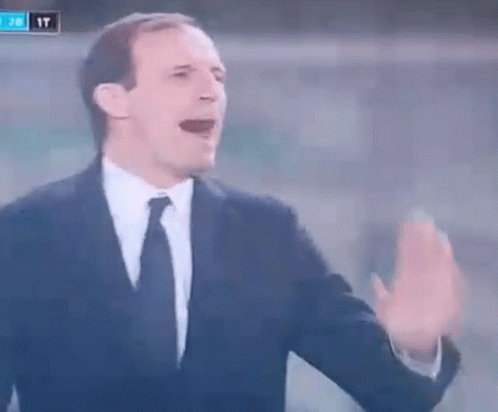

In [8]:
# THIS IS A TEST CELL. DO NOT DELETE IT.

# Generate some test data
gen = np.random.default_rng(1)
X = gen.normal(size=(3, 2))
X -= X.mean(axis=0)  # always centre the data

# Compute the covariance matrix and the eigenvalues/eigenvectors
C = np.cov(X, rowvar=False)
evl, evc = np.linalg.eigh(C)
evl = evl[::-1]  # sort in descending order
evc = evc[:, ::-1]  # sort in descending order

# Compute PCA and compare the results
pca = PCA().fit(X)
if (not hasattr(pca, 'loadings_')) and (not hasattr(pca, 'loadings')):
    display(Image('img/allegri_giacca.gif', width=500))
    raise RuntimeError(
        'The PCA class might not have a saving method for the loadings!')
if not pca._fitted:
    display(Image('img/allegri_giacca.gif', width=500))
    raise RuntimeError(
        'The PCA class does not update the fitted state correctly!')
if not np.allclose(pca.explained_variance_, evl):
    display(Image('img/allegri_dipoco.gif', width=500))
    raise ValueError('Difference in eigenvalues!')
if not np.allclose(sum(pca.explained_variance_ratio_), 1.0):
    display(Image('img/allegri_dipoco.gif', width=500))
    raise ValueError(
        'Difference in explained variance ratios! The sum is %r instead of 1.0!'
        % sum(pca.explained_variance_ratio_))
if not np.allclose(evc @ pca.loadings_.T, np.identity(2)):
    display(Image('img/allegri_dipoco.gif', width=500))
    raise ValueError('Difference in eigenvectors!')

# If everything is OK, print a message
print('All tests passed!')
display(Image('img/allegri_calma.gif', width=500))

### Some Simple Test

We then proceed to apply PCA on a simple test dataset to better understand its function.
We first generate some data according to a known multivariate 2D distribution

$$
\mathcal{N}(\mathbf{x} ~\mid~ \mathbf{\mu}, \mathbf{\Sigma})
=
\frac{1}{2 \pi \sqrt{\det{\mathbf{\Sigma}}}}
\exp\left({-\left(\mathbf{x} - \mathbf{\mu}\right)^T \mathbf{\Sigma}^{-1} \left(\mathbf{x} - \mathbf{\mu} \right)}\right),
$$

where $\mathbf{\Sigma}$ is the population covariance matrix, and $\mathbf{\mu}$ is the population mean.

In [9]:
gen = np.random.default_rng(123)
X = gen.multivariate_normal(mean=[0, 0], cov=[[3, 3], [3, 4]], size=1000)

We can then instantiate the PCA object we just computed.

In [10]:
pca = PCA()

But how can we visualise the data? And how about the principal directions (the loadings)?

For data, this is rather easy, as we can straightforwardly plot the data matrix $X$ using a scatter plot.

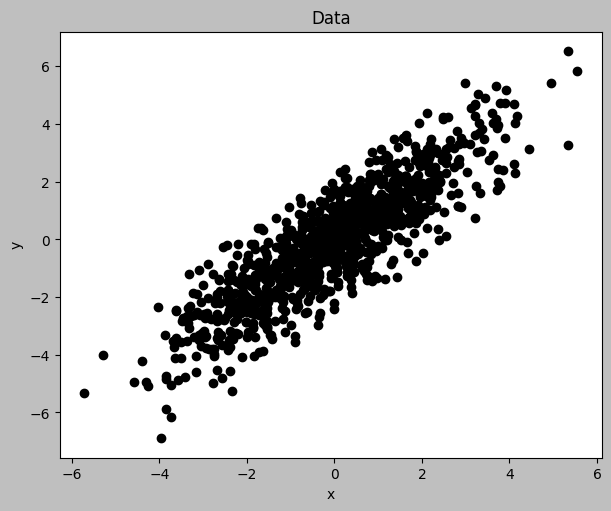

In [11]:
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')
ax.scatter(X[..., 0], X[..., 1], label='data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')
plt.show()

We the fit and transform the data, in order to obtain the principal components (scores) and the loadings.

In [12]:
Xp, W = pca.fit_transform(X)

**QUESTION**: we know that a positive semi-definite matrix $C$ can be diagonalised as $C = W \Lambda W^T$, where $\Lambda$ is a diagonal matrix.
Is this transformation unique? Do you think you can identify the symmetry group?

We then plot the loadings on the data.
To visualise them better, it might be appropriate to rescale them by the corresponding variance.

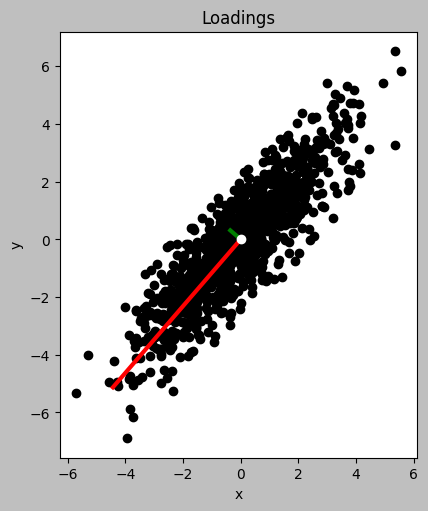

In [13]:
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')
ax.scatter(X[..., 0], X[..., 1], label='data')  # plot the data

# Rescale the loadings W' = S . W
Wp = np.diag(pca.explained_variance_) @ W

# Plot the loadings
ax.plot([0, Wp[0, 0]], [0, Wp[0, 1]], 'r-', lw=3)
ax.plot([0, Wp[1, 0]], [0, Wp[1, 1]], 'g-', lw=3)
ax.plot([0], [0], 'wo', lw=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Loadings')
ax.set_aspect('equal')  # this ensures that orthigonality is visible
plt.show()

Finally, we are ready to visualise the transformation of the data to principal components.

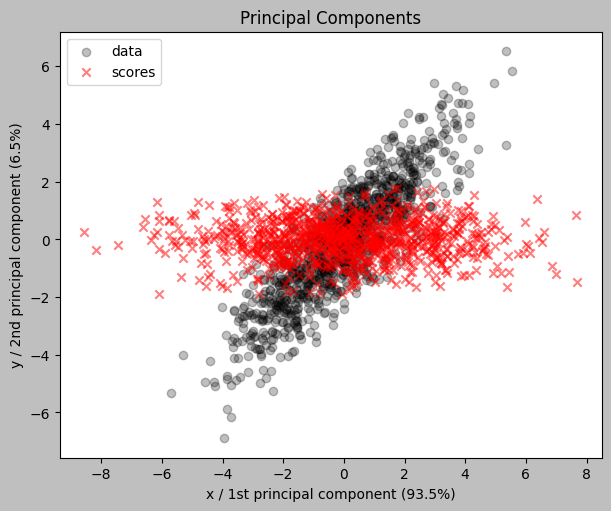

In [14]:
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')
ax.scatter(X[..., 0], X[..., 1], label='data', alpha=0.25)
ax.scatter(Xp[..., 0],
           Xp[..., 1],
           label='scores',
           color='r',
           marker='x',
           alpha=0.5)
ax.legend()
ax.set_xlabel(
    f'x / 1st principal component ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(
    f'y / 2nd principal component ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Principal Components')
plt.show()

## Principal Components Analysis and Computer Vision

We tackle now one of the first uses of PCA for computer vision.
We are talking about the decomposition of human faces for people identification (see [Sirovich and Kirby (1987)](https://doi.org/10.1364%2FJOSAA.4.000519)).

We shall download the ["Olivetti AT&T" dataset](https://cs.nyu.edu/~roweis/data.html) and analyse its decomposition with PCA.
The dataset contains 400 faces of 40 individuals in 64x64 pixel grayscale images.

In [15]:
faces, face_ids = fetch_olivetti_faces(return_X_y=True,
                                       shuffle=True,
                                       random_state=42)

# Split the dataset into train and test sets
gen = np.random.default_rng(42)
split = gen.binomial(n=1, p=0.8, size=faces.shape[0]).astype('bool')

X_train, y_train = faces[split], face_ids[split]
X_test, y_test = faces[~split], face_ids[~split]

print(
    f'Test set: {X_test.shape} (i.e. {X_test.shape[0] / faces.shape[0]:.1%})')

# Spare a few samples for validation
split = gen.binomial(n=1, p=0.2, size=X_train.shape[0]).astype('bool')

X_val, y_val = X_train[split], y_train[split]
X_train, y_train = X_train[~split], y_train[~split]

print(
    f'Validation set: {X_val.shape} (i.e. {X_val.shape[0] / X_train.shape[0]:.1%})'
)
print(
    f'Training set: {X_train.shape} (i.e. {X_train.shape[0] / faces.shape[0]:.1%})'
)

Test set: (75, 4096) (i.e. 18.8%)
Validation set: (69, 4096) (i.e. 27.0%)
Training set: (256, 4096) (i.e. 64.0%)


First, we visualise data from the training set, in order to get an idea of what we are dealing with.

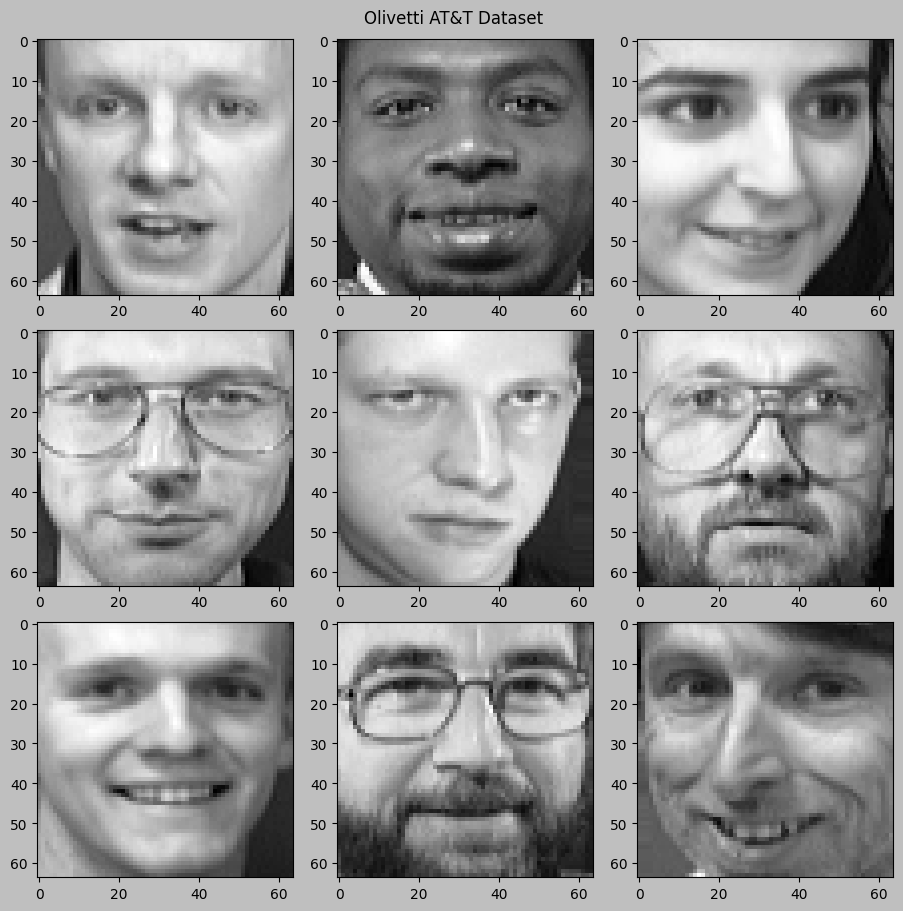

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(9, 9), layout='constrained')
fig.suptitle('Olivetti AT&T Dataset')
ax = ax.ravel()
for n in range(9):
    ax[n].imshow(X_train[n].reshape(64, 64))  # reshape the data to 64x64
plt.show()

We can then apply the PCA to the data (let us keep all components).
We shall, however, need to first centre the data.

In [17]:
pca = PCA()
X_train_pca, loadings = pca.fit_transform(X_train)
X_val_pca, _ = pca.transform(X_val)
X_test_pca, _ = pca.transform(X_test)

For the sake of completeness, let us visualise the disposition of the scores in different ways.
Consider first a 3D plot of the scores.

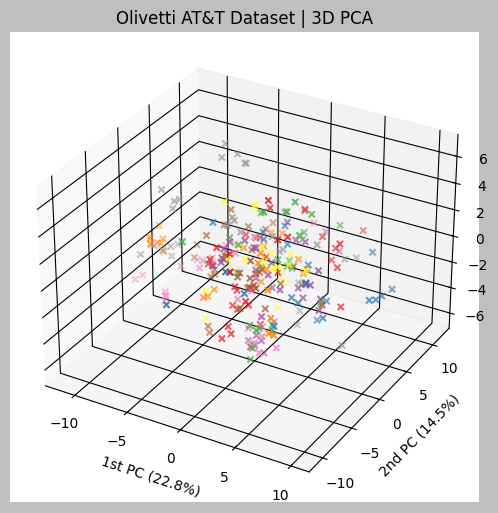

In [18]:
fig, ax = plt.subplots(figsize=(6, 5),
                       layout='constrained',
                       subplot_kw={'projection': '3d'})
ax.scatter(X_train_pca[..., 0],
           X_train_pca[..., 1],
           X_train_pca[..., 2],
           c=y_train,
           cmap='Set1',
           marker='x')
ax.set_xlabel(f'1st PC ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'2nd PC ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'3rd PC ({pca.explained_variance_ratio_[2]:.1%})')
ax.set_title('Olivetti AT&T Dataset | 3D PCA')
plt.show()

We might have picked up something, but probably not enough in 3D.
Let us take a look with an orthogonal projection in 2D space.

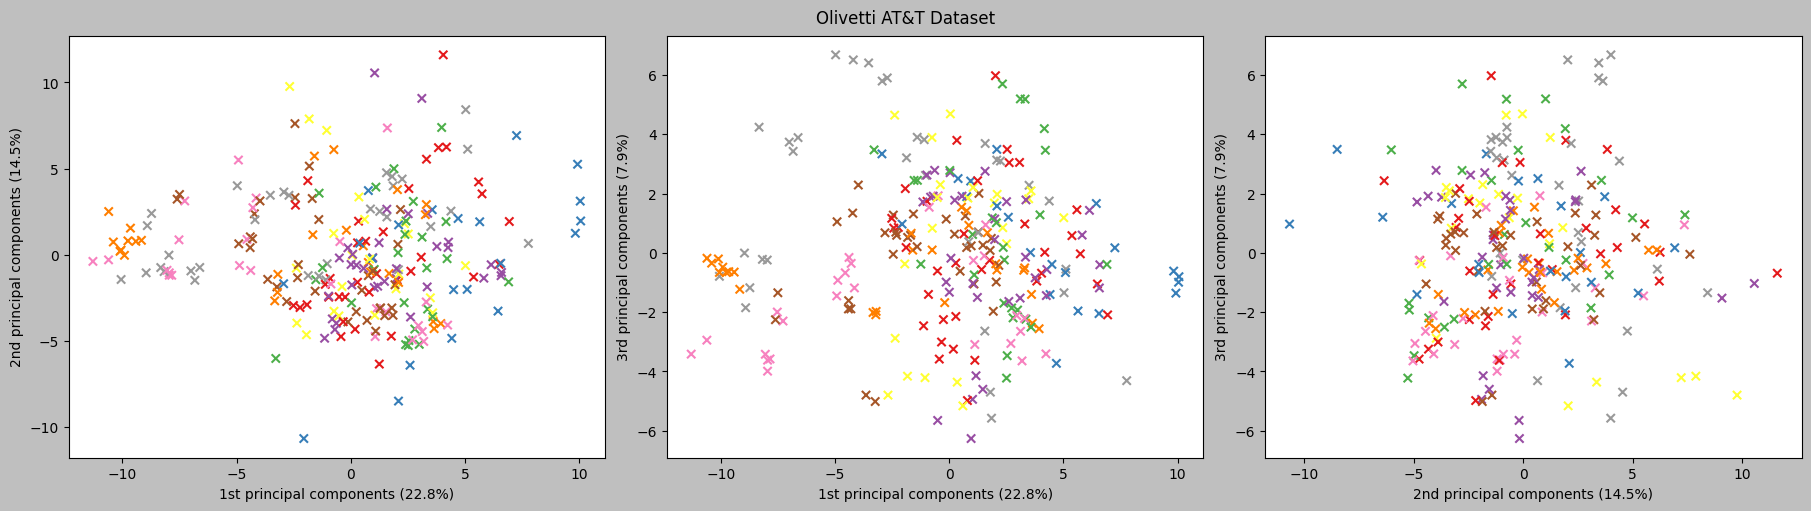

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5), layout='constrained')
ax[0].scatter(X_train_pca[..., 0],
              X_train_pca[..., 1],
              c=y_train,
              cmap='Set1',
              marker='x')
ax[1].scatter(X_train_pca[..., 0],
              X_train_pca[..., 2],
              c=y_train,
              cmap='Set1',
              marker='x')
ax[2].scatter(X_train_pca[..., 1],
              X_train_pca[..., 2],
              c=y_train,
              cmap='Set1',
              marker='x')
ax[0].set_xlabel(
    f'1st principal components ({pca.explained_variance_ratio_[0]:.1%})')
ax[0].set_ylabel(
    f'2nd principal components ({pca.explained_variance_ratio_[1]:.1%})')
ax[1].set_xlabel(
    f'1st principal components ({pca.explained_variance_ratio_[0]:.1%})')
ax[1].set_ylabel(
    f'3rd principal components ({pca.explained_variance_ratio_[2]:.1%})')
ax[2].set_xlabel(
    f'2nd principal components ({pca.explained_variance_ratio_[1]:.1%})')
ax[2].set_ylabel(
    f'3rd principal components ({pca.explained_variance_ratio_[2]:.1%})')
fig.suptitle('Olivetti AT&T Dataset')
plt.show()

It still does not seem to be enough, even though some of the principal components seem to be grouped/clustered together.
Let us take a closer look to the explained variance ratio.

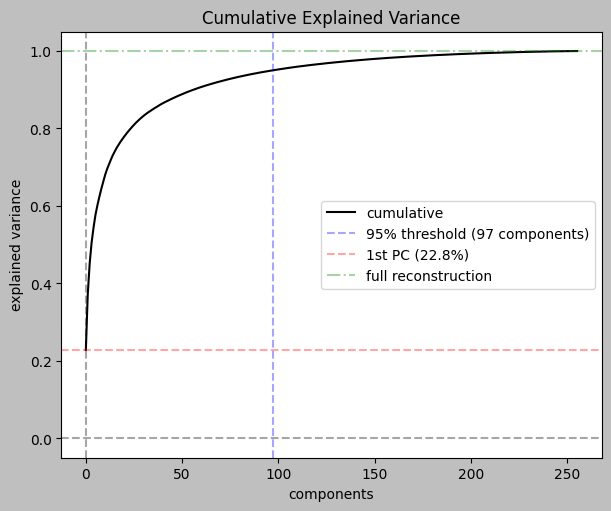

In [20]:
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')
y = np.cumsum(pca.explained_variance_ratio_)
ax.plot(y, 'k-', label='cumulative')
ax.set_xlabel('components')
ax.set_ylabel('explained variance')
ax.set_title('Cumulative Explained Variance')
ax.axvline(0, 0, 1, ls='--', alpha=0.35)
ax.axhline(0, 0, 1, ls='--', alpha=0.35)
ax.axvline((y >= 0.95).argmax(),
           0,
           1,
           color='b',
           ls='--',
           alpha=0.35,
           label=f'95% threshold ({(y >= 0.95).argmax():d} components)')
ax.axhline(y[0],
           0,
           1,
           color='r',
           ls='--',
           alpha=0.35,
           label=f'1st PC ({pca.explained_variance_ratio_[0]:.1%})')
ax.axhline(1,
           0,
           1,
           color='g',
           ls='-.',
           alpha=0.35,
           label='full reconstruction')
ax.legend()
plt.show()

Apparently, we might need well more than 3 principal components, after all.
For completeness, let us visualise the loadings.

**QUESTION**: the loadings are the coefficients of the PCA transformation.
Their support is the original features (pixels in this case).
How can we best visualise the loadings, in this scenario?

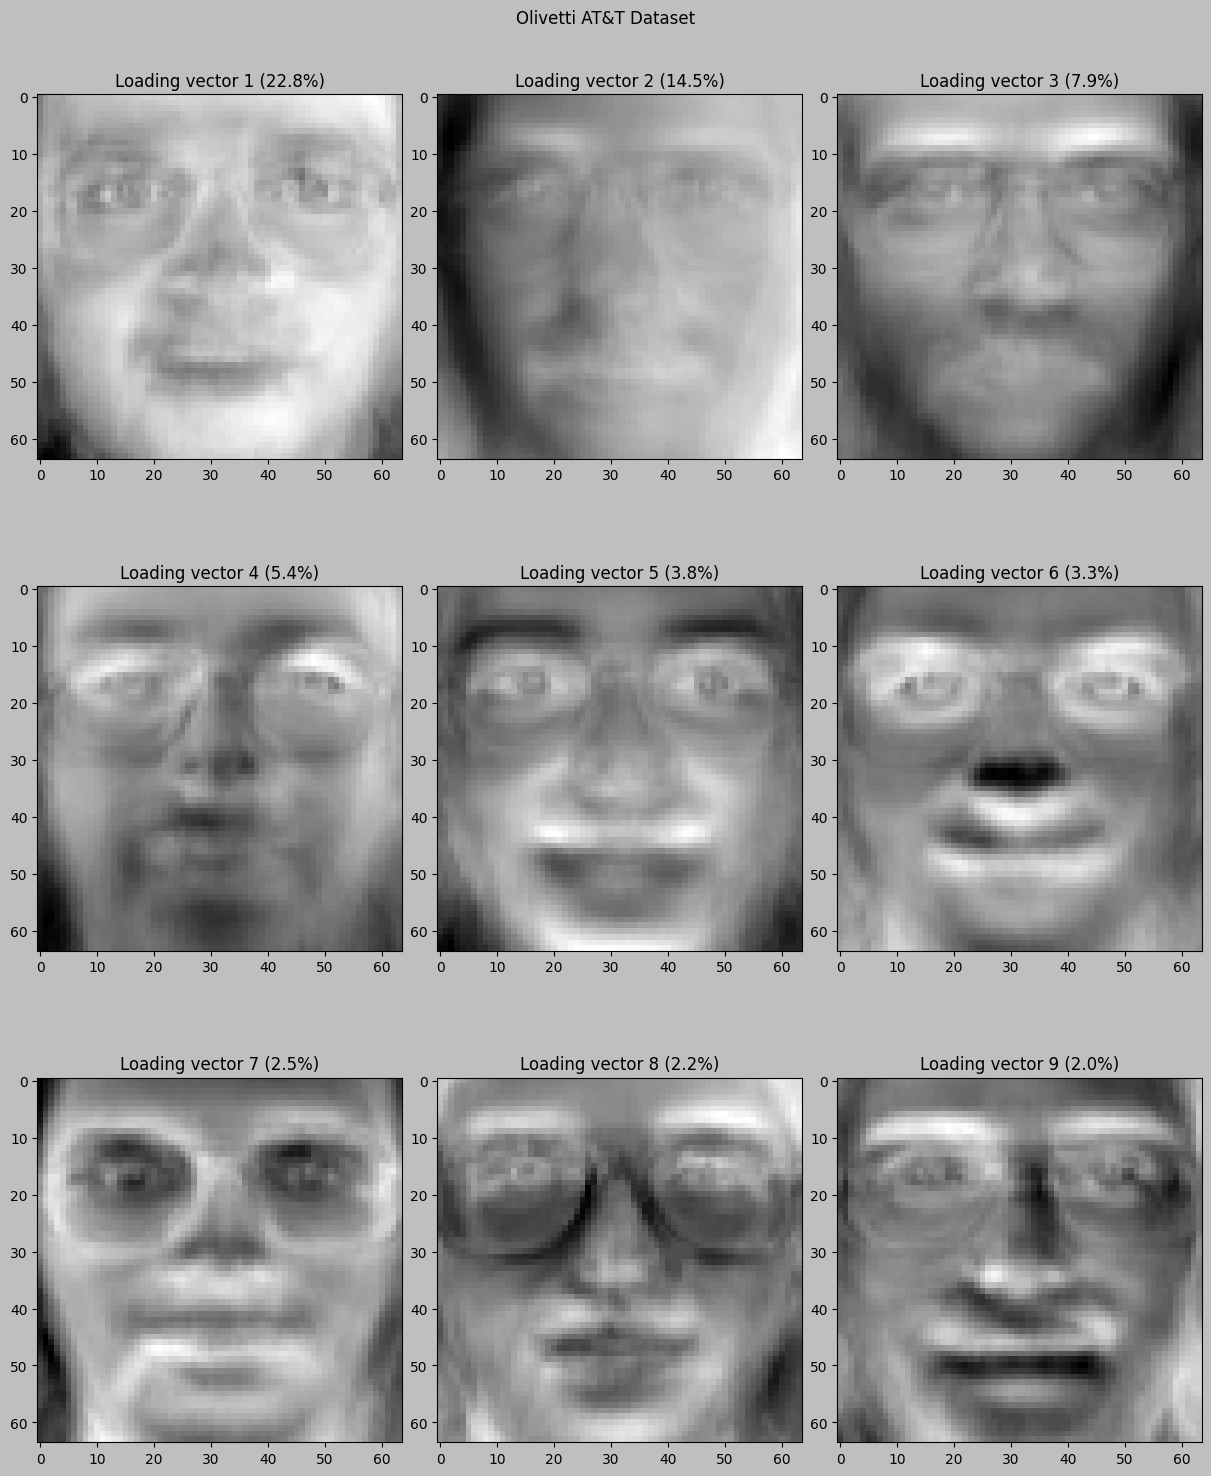

In [21]:
fig, ax = plt.subplots(ncols=3,
                       nrows=3,
                       figsize=(12, 15),
                       layout='constrained')
fig.suptitle('Olivetti AT&T Dataset')
ax = ax.ravel()
for n in range(9):
    ax[n].imshow(loadings[..., n].reshape(64, 64))
    ax[n].set_title(
        f'Loading vector {n+1:d} ({pca.explained_variance_ratio_[n]:.1%})')
plt.show()

### An Attempt at Classification

Using the principal components, we try to classify images using a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In particular, we use look for the best number of components to use, through validation data.

/home/catA/rf265700/Documents/obsidian/Labo/Formations/AIPhy/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/catA/rf265700/Documents/obsidian/Labo/Formations/AIPhy/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/catA/rf265700/Documents/obsidian/Labo/Formations/AIPhy/code/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use

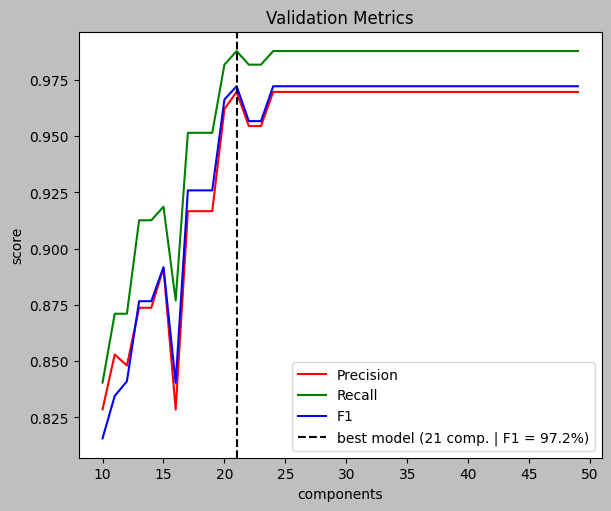

In [23]:
metrics = {'n_components': [], 'precision': [], 'recall': [], 'f1': []}

clf = LogisticRegression()
for n in range(10, 50):  # number of components

    # Train the model
    clf = clf.fit(X_train_pca[..., :n], y_train)

    # Make predictions
    y_pred = clf.predict(X_val_pca[..., :n])

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_val,
                                                               y_pred,
                                                               average='macro')
    metrics['n_components'].append(n)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)

# Convert to array
metrics = {k: np.array(v) for k, v in metrics.items()}
x_best, y_best = np.argmax(metrics['f1']) + 10, np.max(metrics['f1'])

# Plot the results
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')

## Metrics
ax.plot(metrics['n_components'], metrics['precision'], 'r-', label='Precision')
ax.plot(metrics['n_components'], metrics['recall'], 'g-', label='Recall')
ax.plot(metrics['n_components'], metrics['f1'], 'b-', label='F1')

## Best model line
ax.axvline(x_best,
           0,
           1,
           color='k',
           ls='--',
           label=f'best model ({x_best:d} comp. | F1 = {y_best:.1%})')
ax.set_xlabel('components')
ax.set_ylabel('score')
ax.set_title('Validation Metrics')
ax.legend()
plt.show()

Finally, we predict the test labels:

In [24]:
clf = LogisticRegression().fit(X_train_pca[..., :x_best], y_train)
y_pred = clf.predict(X_test_pca[..., :x_best])

# Compute metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test,
                                                           y_pred,
                                                           average='macro')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')

Precision: 95.14%
Recall: 95.14%
F1: 94.24%
